In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import glob
import keras
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
fleisch = pd.read_excel('Archive_files/Archiv/Fleisch.xls')
stoff =pd.read_excel('Archive_files/Archiv/Stoff.xls')
leder = pd.read_excel('Archive_files/Archiv/Leder.xls')
holz = pd.read_excel('Archive_files/Archiv/Holz.xls')
haut = pd.read_excel('Archive_files/Archiv/Referenz-Haut_6-Klassen.xls')

print('================================================================')
print(' Data sets shapes')
print('Fleisch ', fleisch.shape)
print('Stoff ', stoff.shape)
print('Leder ', leder.shape)
print('Haut ', haut.shape)
print('Holz ', holz.shape)

 Data sets shapes
Fleisch  (121, 71)
Stoff  (121, 11)
Leder  (121, 30)
Haut  (121, 7)
Holz  (121, 63)


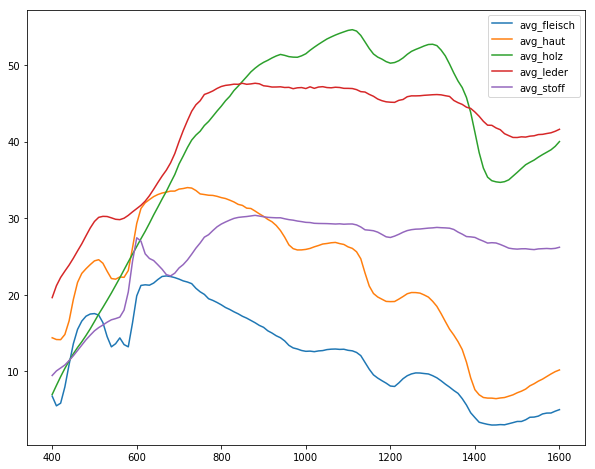

In [3]:
avg_fleisch = np.array(fleisch.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_leder = np.array(leder.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_holz = np.array(holz.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_stoff = np.array(stoff.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_haut = np.array(haut.iloc[:,1:].mean(axis = 1))[np.newaxis].T

wavelength = np.array(fleisch['nm'])[np.newaxis].T
plt.figure(figsize=[10,8])
plt.plot(wavelength,avg_fleisch,label='avg_fleisch')
plt.plot(wavelength,avg_haut,label='avg_haut')
plt.plot(wavelength,avg_holz,label='avg_holz')
plt.plot(wavelength,avg_leder,label='avg_leder')
plt.plot(wavelength,avg_stoff,label='avg_stoff')

plt.legend()

In [4]:
from sklearn.decomposition import PCA

def dataCleanup(data):

    gross_avg = np.array(data.iloc[:,1:].mean(axis = 1))

    # print('average of the combined dataset={}'.format(gross_avg.shape))

    mean_removed_data = data.subtract(gross_avg, axis = 0)
    
#     mean_removed_data.index

    pca = PCA(n_components=5)

    pca.fit(mean_removed_data)

    cleaned_data = pca.transform(mean_removed_data)    
    
    print('number of components selected to maintain = {}'.format(pca.n_components_))
    print('the variance ratio for each component = {}'.format(pca.explained_variance_ratio_))

    cleaned_data = pd.DataFrame(index = mean_removed_data.index, data = cleaned_data)
    return cleaned_data


In [5]:
# print ('fleisch shape={}\n haut shape={}\n holz shape={}\n leder shape={}\n stoff shape={}'\
# .format(fleisch.shape, haut.shape, holz.shape, leder.shape, stoff.shape))

res = fleisch.set_index('nm').combine_first(haut.set_index('nm')).combine_first(holz.set_index('nm'))\
.combine_first(leder.set_index('nm')).combine_first(stoff.set_index('nm'))

In [6]:
print('=========================================================================')
print("Performing PCA on the dataset to use the features with more relevance")
print('=========================================================================')

print('------------- FLEISCH -------------')
fleisch_cleaned = dataCleanup(fleisch.set_index('nm'))
print('-------------   HAUT  -------------')
haut_cleaned = dataCleanup(haut.set_index('nm'))
print('-------------   HOLZ  -------------')
holz_cleaned = dataCleanup(holz.set_index('nm'))
print('-------------  LEDER  -------------')
leder_cleaned = dataCleanup(leder.set_index('nm'))
print('-------------  STOFF  -------------')
stoff_cleaned = dataCleanup(stoff.set_index('nm'))


print('=========================================================================')
print("Creating the labels to train the network")
print('=========================================================================')
fleisch_labels = np.ones((len(fleisch_cleaned),1))
print("Fleisch Labels: ",fleisch_labels.shape)
haut_labels = np.ones((len(haut_cleaned),1))
print("Haut Labels: ",haut_labels.shape)
holz_labels = np.zeros((len(holz_cleaned),1))
print("Holz Labels: ",holz_labels.shape)
leder_labels = np.zeros((len(leder_cleaned),1))
print("Leder Labels: ",leder_labels.shape)
stoff_labels = np.zeros((len(stoff_cleaned),1))
print("Stoff Labels: ", stoff_labels.shape)

print('=========================================================================')
print("Combining all the datasets and labels")
print('=========================================================================')
ultimate_dataset = np.vstack((fleisch_cleaned, holz_cleaned, leder_cleaned, haut_cleaned,\
                             stoff_cleaned))
print("Dataset size: ", ultimate_dataset.shape)
ultimate_labels = np.vstack((fleisch_labels, holz_labels, leder_labels, haut_labels,\
                            stoff_labels))
print("Dataset labels size: ", ultimate_labels.shape)

Performing PCA on the dataset to use the features with more relevance
------------- FLEISCH -------------
number of components selected to maintain = 5
the variance ratio for each component = [0.49438838 0.41809529 0.05047013 0.01283651 0.01124949]
-------------   HAUT  -------------
number of components selected to maintain = 5
the variance ratio for each component = [9.16839731e-01 4.61027036e-02 3.46245442e-02 2.03902143e-03
 3.94000293e-04]
-------------   HOLZ  -------------
number of components selected to maintain = 5
the variance ratio for each component = [0.63740184 0.26904605 0.0667461  0.0104745  0.00637513]
-------------  LEDER  -------------
number of components selected to maintain = 5
the variance ratio for each component = [0.83680613 0.08715375 0.04253931 0.02081826 0.00662753]
-------------  STOFF  -------------
number of components selected to maintain = 5
the variance ratio for each component = [0.66468473 0.29682578 0.02128887 0.01312459 0.00335548]
Creating the l

In [7]:



# kfold_splits = 5

# skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)

# # Loop through the indices the split() method returns
# for index, (train_indices, val_indices) in enumerate(skf.split(X, y)):
#     print "Training on fold " + str(index+1) + "/10..."
#     # Generate batches from indices
#     xtrain, xval = X[train_indices], X[val_indices]
#     ytrain, yval = y[train_indices], y[val_indices]


In [32]:
mlp = Sequential()
mlp.add(Dense(units = 5,input_dim = 5, init = 'uniform'))
mlp.add(Dense(units = 10, activation='relu'))
mlp.add(Dense(units = 6, activation='relu'))
mlp.add(Dense(units = 1, activation ='sigmoid'))

mlp.compile(loss='mean_absolute_error',
              optimizer= keras.optimizers.SGD(lr=0.12, momentum=0.1, nesterov=True),
              metrics=['accuracy'])

mlp.fit(ultimate_dataset, ultimate_labels, epochs = 15, batch_size = 201)

Epoch 1/15
605/605 [==============================] - 0s 9us/step - loss: 0.1798 - acc: 0.8446
Epoch 2/15
605/605 [==============================] - 0s 8us/step - loss: 0.2378 - acc: 0.7752
Epoch 3/15
605/605 [==============================] - 0s 13us/step - loss: 0.2188 - acc: 0.7884
Epoch 4/15
605/605 [==============================] - 0s 10us/step - loss: 0.2012 - acc: 0.8149
Epoch 5/15
605/605 [==============================] - 0s 12us/step - loss: 0.1905 - acc: 0.8182
Epoch 6/15
605/605 [==============================] - 0s 9us/step - loss: 0.1843 - acc: 0.8264
Epoch 7/15
605/605 [==============================] - 0s 9us/step - loss: 0.1816 - acc: 0.8347
Epoch 8/15
605/605 [==============================] - 0s 12us/step - loss: 0.1870 - acc: 0.8347
Epoch 9/15
605/605 [==============================] - 0s 10us/step - loss: 0.1767 - acc: 0.8397
Epoch 10/15
605/605 [==============================] - 0s 15us/step - loss: 0.1745 - acc: 0.8463
Epoch 11/15
605/605 [======================

In [41]:
mlp = Sequential()
mlp.add(Dense(units = 5,input_dim = 5, init = 'uniform'))
mlp.add(Dense(units = 10, activation='relu'))
mlp.add(Dense(units = 6, activation='relu'))
mlp.add(Dense(units = 1, activation ='sigmoid'))

mlp.compile(loss='logcosh',
              optimizer= keras.optimizers.SGD(lr=0.12, momentum=0.1, nesterov=True),
              metrics=['accuracy'])
mlp.fit(ultimate_dataset, ultimate_labels, epochs = 15, batch_size = 201)

Epoch 1/15
605/605 [==============================] - 0s 437us/step - loss: 0.0636 - acc: 0.8512
Epoch 2/15
605/605 [==============================] - 0s 8us/step - loss: 0.0696 - acc: 0.8364
Epoch 3/15
605/605 [==============================] - 0s 7us/step - loss: 0.0665 - acc: 0.8446
Epoch 4/15
605/605 [==============================] - 0s 7us/step - loss: 0.0652 - acc: 0.8479
Epoch 5/15
605/605 [==============================] - 0s 11us/step - loss: 0.0645 - acc: 0.8545
Epoch 6/15
605/605 [==============================] - 0s 9us/step - loss: 0.0639 - acc: 0.8579
Epoch 7/15
605/605 [==============================] - 0s 11us/step - loss: 0.0636 - acc: 0.8595
Epoch 8/15
605/605 [==============================] - 0s 11us/step - loss: 0.0633 - acc: 0.8595
Epoch 9/15
605/605 [==============================] - 0s 11us/step - loss: 0.0630 - acc: 0.8595
Epoch 10/15
605/605 [==============================] - 0s 12us/step - loss: 0.0627 - acc: 0.8595
Epoch 11/15
605/605 [=====================

## Implementing Cross Validation

In [130]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(ultimate_dataset, ultimate_labels):
    # create model
    mlp = Sequential()
    mlp.add(Dense(units = 5,input_dim = 5, init = 'uniform'))
    mlp.add(Dense(units = 10, activation='relu'))
    mlp.add(Dense(units = 6, activation='relu'))
    mlp.add(Dense(units = 1, activation ='sigmoid'))

#     mlp.compile(loss='logcosh',
#               optimizer= keras.optimizers.SGD(lr=0.12, momentum=0.1, nesterov=True),
#               metrics=['accuracy'])
    mlp.compile(loss='logcosh',
              optimizer= 'adam',
              metrics=['accuracy'])
    mlp.fit(ultimate_dataset[train], ultimate_labels[train], epochs = 100, batch_size = 10)
    
    # evaluate the model
    scores = mlp.evaluate(ultimate_dataset[test], ultimate_labels[test], verbose=0)
    print("%s: %.2f%%" % (mlp.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))


Epoch 1/100
483/483 [==============================] - 2s 4ms/step - loss: 0.1134 - acc: 0.5859
Epoch 2/100
483/483 [==============================] - 0s 202us/step - loss: 0.1078 - acc: 0.6004
Epoch 3/100
483/483 [==============================] - 0s 207us/step - loss: 0.1036 - acc: 0.6004
Epoch 4/100
483/483 [==============================] - 0s 232us/step - loss: 0.0990 - acc: 0.6004
Epoch 5/100
483/483 [==============================] - 0s 209us/step - loss: 0.0953 - acc: 0.6128
Epoch 6/100
483/483 [==============================] - 0s 205us/step - loss: 0.0922 - acc: 0.6273
Epoch 7/100
483/483 [==============================] - 0s 214us/step - loss: 0.0894 - acc: 0.6335
Epoch 8/100
483/483 [==============================] - 0s 226us/step - loss: 0.0875 - acc: 0.6522
Epoch 9/100
483/483 [==============================] - 0s 209us/step - loss: 0.0859 - acc: 0.6874
Epoch 10/100
483/483 [==============================] - 0s 219us/step - loss: 0.0838 - acc: 0.6874
Epoch 11/100
483/483 

483/483 [==============================] - 0s 164us/step - loss: 0.0299 - acc: 0.9337
Epoch 84/100
483/483 [==============================] - 0s 175us/step - loss: 0.0296 - acc: 0.9337
Epoch 85/100
483/483 [==============================] - 0s 176us/step - loss: 0.0298 - acc: 0.9296
Epoch 86/100
483/483 [==============================] - 0s 180us/step - loss: 0.0295 - acc: 0.9317
Epoch 87/100
483/483 [==============================] - 0s 172us/step - loss: 0.0304 - acc: 0.9296
Epoch 88/100
483/483 [==============================] - 0s 172us/step - loss: 0.0298 - acc: 0.9275
Epoch 89/100
483/483 [==============================] - 0s 185us/step - loss: 0.0296 - acc: 0.9296
Epoch 90/100
483/483 [==============================] - 0s 173us/step - loss: 0.0289 - acc: 0.9337
Epoch 91/100
483/483 [==============================] - 0s 168us/step - loss: 0.0289 - acc: 0.9337
Epoch 92/100
483/483 [==============================] - 0s 167us/step - loss: 0.0288 - acc: 0.9358
Epoch 93/100
483/483 [=

483/483 [==============================] - 0s 211us/step - loss: 0.0198 - acc: 0.9503
Epoch 66/100
483/483 [==============================] - 0s 248us/step - loss: 0.0195 - acc: 0.9545
Epoch 67/100
483/483 [==============================] - 0s 180us/step - loss: 0.0193 - acc: 0.9565
Epoch 68/100
483/483 [==============================] - 0s 178us/step - loss: 0.0190 - acc: 0.9503
Epoch 69/100
483/483 [==============================] - 0s 168us/step - loss: 0.0189 - acc: 0.9524
Epoch 70/100
483/483 [==============================] - 0s 188us/step - loss: 0.0196 - acc: 0.9462
Epoch 71/100
483/483 [==============================] - 0s 161us/step - loss: 0.0184 - acc: 0.9607
Epoch 72/100
483/483 [==============================] - 0s 163us/step - loss: 0.0179 - acc: 0.9524
Epoch 73/100
483/483 [==============================] - 0s 160us/step - loss: 0.0179 - acc: 0.9565
Epoch 74/100
483/483 [==============================] - 0s 152us/step - loss: 0.0178 - acc: 0.9524
Epoch 75/100
483/483 [=

484/484 [==============================] - 0s 165us/step - loss: 0.0352 - acc: 0.8802
Epoch 48/100
484/484 [==============================] - 0s 166us/step - loss: 0.0352 - acc: 0.8781
Epoch 49/100
484/484 [==============================] - 0s 195us/step - loss: 0.0350 - acc: 0.8740
Epoch 50/100
484/484 [==============================] - 0s 166us/step - loss: 0.0348 - acc: 0.8802
Epoch 51/100
484/484 [==============================] - 0s 171us/step - loss: 0.0342 - acc: 0.8822
Epoch 52/100
484/484 [==============================] - 0s 170us/step - loss: 0.0337 - acc: 0.8822
Epoch 53/100
484/484 [==============================] - 0s 178us/step - loss: 0.0336 - acc: 0.8926
Epoch 54/100
484/484 [==============================] - 0s 173us/step - loss: 0.0329 - acc: 0.8905
Epoch 55/100
484/484 [==============================] - 0s 181us/step - loss: 0.0326 - acc: 0.8864
Epoch 56/100
484/484 [==============================] - 0s 170us/step - loss: 0.0323 - acc: 0.8946
Epoch 57/100
484/484 [=

485/485 [==============================] - 0s 178us/step - loss: 0.0495 - acc: 0.8619
Epoch 30/100
485/485 [==============================] - 0s 185us/step - loss: 0.0486 - acc: 0.8680
Epoch 31/100
485/485 [==============================] - 0s 190us/step - loss: 0.0482 - acc: 0.8722
Epoch 32/100
485/485 [==============================] - 0s 167us/step - loss: 0.0477 - acc: 0.8763
Epoch 33/100
485/485 [==============================] - 0s 164us/step - loss: 0.0468 - acc: 0.8763
Epoch 34/100
485/485 [==============================] - 0s 176us/step - loss: 0.0458 - acc: 0.8701
Epoch 35/100
485/485 [==============================] - 0s 165us/step - loss: 0.0455 - acc: 0.8722
Epoch 36/100
485/485 [==============================] - 0s 174us/step - loss: 0.0436 - acc: 0.8825
Epoch 37/100
485/485 [==============================] - 0s 202us/step - loss: 0.0433 - acc: 0.8742
Epoch 38/100
485/485 [==============================] - 0s 188us/step - loss: 0.0428 - acc: 0.8784
Epoch 39/100
485/485 [=

485/485 [==============================] - 0s 174us/step - loss: 0.0786 - acc: 0.8062
Epoch 12/100
485/485 [==============================] - 0s 171us/step - loss: 0.0761 - acc: 0.8124
Epoch 13/100
485/485 [==============================] - 0s 172us/step - loss: 0.0746 - acc: 0.8144
Epoch 14/100
485/485 [==============================] - 0s 181us/step - loss: 0.0723 - acc: 0.8247
Epoch 15/100
485/485 [==============================] - 0s 182us/step - loss: 0.0702 - acc: 0.8186
Epoch 16/100
485/485 [==============================] - 0s 157us/step - loss: 0.0682 - acc: 0.8247
Epoch 17/100
485/485 [==============================] - 0s 155us/step - loss: 0.0664 - acc: 0.8412
Epoch 18/100
485/485 [==============================] - 0s 164us/step - loss: 0.0647 - acc: 0.8351
Epoch 19/100
485/485 [==============================] - 0s 159us/step - loss: 0.0633 - acc: 0.8515
Epoch 20/100
485/485 [==============================] - 0s 156us/step - loss: 0.0612 - acc: 0.8330
Epoch 21/100
485/485 [=

485/485 [==============================] - 0s 156us/step - loss: 0.0138 - acc: 0.9629
Epoch 94/100
485/485 [==============================] - 0s 156us/step - loss: 0.0135 - acc: 0.9649
Epoch 95/100
485/485 [==============================] - 0s 175us/step - loss: 0.0130 - acc: 0.9649
Epoch 96/100
485/485 [==============================] - 0s 159us/step - loss: 0.0126 - acc: 0.9670
Epoch 97/100
485/485 [==============================] - 0s 160us/step - loss: 0.0126 - acc: 0.9691
Epoch 98/100
485/485 [==============================] - 0s 162us/step - loss: 0.0124 - acc: 0.9691
Epoch 99/100
485/485 [==============================] - 0s 168us/step - loss: 0.0126 - acc: 0.9670
Epoch 100/100
485/485 [==============================] - 0s 176us/step - loss: 0.0123 - acc: 0.9670
acc: 95.00%
92.08% (+/- 5.34%)
